# Research Question No. 2

## How frequent are long-lived bugs in FLOSS project?

## Experimental parameters


| Project                    |         #Reports     |       #Thesholds     |
|----------------------------|:--------------------:|:--------------------:|
| Eclipse                    |        9998         |         365          |
| GCC                        |        9998         |         365          |
| Gnome                      |        7991          |         365          |
| Freedesktop                |        7712          |         365          |
| Mozilla                    |        9998          |         365          |
| WineHQ                     |        6073          |         365          |

Every bug which its report have indicated that the number of days to resolve is less than or equal to **threshold fixed** was considered a **non-long lived bug** and that which the number of days to resolve is greater than this threshold was considered as a **long-live bug**. 

## Step1. Setup environment.

In [33]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [34]:
import matplotlib.pyplot as plt 
import nltk 
import numpy as np
import os 
import pandas as pd
import seaborn as sns 
import string
import re

from nltk.stem   import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Setup Seaborn
sns.set_context("paper")
sns.set(style="ticks", color_codes=True, font_scale=2)

# Setup Matplotlib
plt.rc('figure', figsize=(20, 20))
plt.style.use('default')
SMALL_SIZE  = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14
plt.rc('font',   size=SMALL_SIZE)       # controls default text sizes
plt.rc('axes',   titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes',   labelsize=SMALL_SIZE)  # fontsize of the x and y labels
plt.rc('xtick',  labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick',  labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)   # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
#%matplotlib inline 

# Setup NLTK
stemmer = PorterStemmer()
nltk.download('punkt')
nltk.download('stopwords')

# Path of the file to read.
projects = ['eclipse', 'freedesktop', 'gnome', 'mozilla', 'gcc', 'winehq']

# Fixed time threshold.
bug_reports_file_prefix  = '20200731'
bug_fix_time_threshold   = 365
print("Setup complete")

Setup complete


[nltk_data] Downloading package punkt to /home/gomes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/gomes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 2. Load data.

In [35]:
bug_reports_data_list = []
for project in projects:
    bug_reports_path = f"datasets/{bug_reports_file_prefix}_{project}_bug_report_data.csv"

    # read bug reports data.
    bug_reports_data = pd.read_csv(bug_reports_path)[0:10000]
    rows_and_cols = bug_reports_data.shape
    print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {bug_reports_path}.\n")
    print(f"Mean of bug fix time: {bug_reports_data['bug_fix_time'].mean(axis=0)}.\n")
   
    bug_reports_data["project"] = project  
    bug_reports_data_list.append(bug_reports_data) 

# concatenate all bug_reports_data 
bug_reports_all_data = pd.concat(bug_reports_data_list)

There are 9776 rows and 19 columns in datasets/20200731_eclipse_bug_report_data.csv.

Mean of bug fix time: 102.39453764320785.

There are 7684 rows and 19 columns in datasets/20200731_freedesktop_bug_report_data.csv.

Mean of bug fix time: 173.53669963560645.

There are 7813 rows and 19 columns in datasets/20200731_gnome_bug_report_data.csv.

Mean of bug fix time: 203.92115704594906.

There are 9999 rows and 19 columns in datasets/20200731_mozilla_bug_report_data.csv.

Mean of bug fix time: 278.0985098509851.

There are 10000 rows and 19 columns in datasets/20200731_gcc_bug_report_data.csv.

Mean of bug fix time: 225.8268.

There are 6074 rows and 19 columns in datasets/20200731_winehq_bug_report_data.csv.

Mean of bug fix time: 490.5972999670728.



## Step 3. Preprocess data.

In [36]:
def stem_sentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=set()
    for word in token_words:
        stem_sentence.add(stemmer.stem(word))
        
    return ' '.join(list(stem_sentence))

def clean_text(text):
    """Clean a text.

    Parameters
    ----------
    text: string
        A text string.

    Returns
    -------
    text:string
        A modified initial text string
    """
    if text != text:
        return ' '

    replace_by_space = re.compile("[/(){}\[\]\|@,;]")
    replace_bad_symbols = re.compile('[^0-9a-z #+_]')
    english_stopwords = set(stopwords.words('english'))
    text = text.lower()
    text = replace_by_space.sub(' ', text)
    text = replace_bad_symbols.sub('', text)
    text = ' '.join(word for word in text.split() if word not in english_stopwords)
    return stem_sentence(text)

def get_file_size(project, bugid):
    bugid = re.findall(r"\d+$", bugid)[0]
    file_name=f"/home/gomes/Workspace/doctorate/data/{project}/xml/{project.upper()}-{bugid}.xml"
    info = os.stat(file_name) 
    return info.st_size * 0.000001
    

In [38]:
bug_reports_path = f"datasets/{bug_reports_file_prefix}_bug_reports_all_data.csv"
if (not os.path.exists(bug_reports_path)):
    bug_reports_all_data['short_description'] = bug_reports_all_data['short_description'].fillna(" ")
    bug_reports_all_data['long_description']  = bug_reports_all_data['long_description'].fillna(" ")
    #bug_reports_all_data['short_description_words'] = bug_reports_all_data['short_description'].apply(lambda s: len(clean_text(s).split()))
    #bug_reports_all_data['long_description_words']  = bug_reports_all_data['long_description'].apply(lambda s: len(clean_text(s).split()))
    bug_reports_all_data['long_lived?']  = bug_reports_all_data['bug_fix_time'].apply(lambda t: 'long-lived' if t > bug_fix_time_threshold else 'short-lived')

    bug_reports_all_data.drop(bug_reports_all_data[bug_reports_all_data['severity_category'] == 'not set'].index, inplace=True)
    bug_reports_all_data.drop(bug_reports_all_data[bug_reports_all_data['bug_fix_time'] < 0 ].index, inplace=True)

    #bug_reports_all_data = pd.read_csv(bug_reports_path)
    #bug_reports_dir   = os.path.join('/home/gomes/Workspace/doctorate/data/eclipse/xml/')
    #bug_reports_files = os.listdir(bug_reports_dir)
    #bug_reports_all_data['file_size'] = bug_reports_all_data.apply(lambda x: get_file_size(x['project'], x['bug_id']), axis=1)
    #bug_reports_all_data.nlargest(10, 'file_size')

    bug_reports_all_data.to_csv(bug_reports_path, index=False)
else:
    print(f"{bug_reports_path} exists, read data from it!")
    bug_reports_all_data = pd.read_csv(bug_reports_path)



datasets/20200731_bug_reports_all_data.csv exists, read data from it!


## Step 3. Exploring data analysis

In [17]:
bug_reports_all_data['project'].value_counts()

gcc            9946
mozilla        9945
eclipse        9724
gnome          7772
freedesktop    7644
winehq         6037
Name: project, dtype: int64

In [18]:
bug_reports_all_data.head()

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,...,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,project,short_description_words,long_lived?
0,RECOMMENDERS-467951,2015-05-22,Core,RECOMMENDERS,LogTraceException in ProposalUtils.toMethodNam...,The following incident was reported via the au...,recommenders-inbox,error-reports-inbox,fixed,1,...,2015-05-27,0,2,2015-05-27,5,normal,2,eclipse,3,short-lived
1,QVTO-463396,2015-03-29,Engine,QVTO,CCE in DecorationNodeImpl.eSet (159),The following incident was reported via the au...,serg.boyko2011,error-reports-inbox,fixed,1,...,2015-04-01,0,8,2015-03-31,2,normal,2,eclipse,3,short-lived
2,EQUINOX-530069,2018-01-20,Compendium,EQUINOX,[http servlet] During dispatching javax.servle...,Original issue https://issues.liferay.com/brow...,raymond.auge,raymond.auge,fixed,1,...,2018-01-22,0,3,2018-01-22,2,normal,2,eclipse,10,short-lived
3,NATTABLE-422482,2013-11-25,Core,NATTABLE,Left border of NatTable is not drawn,Rendering a NatTable on a Composite with margi...,dirk.fauth,dirk.fauth,fixed,1,...,2014-07-23,0,3,2013-11-25,0,normal,2,eclipse,4,short-lived
4,WTP_JAVA_EE_TOOLS-116294,2005-11-14,jst.j2ee,WTP_JAVA_EE_TOOLS,NPE while importing EAR with utility jar,Import and EAR which has EJb and Ejb client tr...,jsholl,nagrawal,fixed,1,...,2005-12-09,0,4,2005-11-15,1,blocker,6,eclipse,5,short-lived


In [26]:
bug_reports_all_data.loc[bug_reports_all_data['project']=='gcc'].nlargest(1, 'bug_fix_time')

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,...,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,project,short_description_words,long_lived?
42367,GCC-7221,2002-07-06,c++,GCC,wrong linkage of typedef-named classes,Given:\n\n typedef struct {\n void f()\n ...,unassigned,aoliva,fixed,1,...,2017-02-28,0,8,2017-02-28,5351,normal,2,gcc,4,long-lived


In [28]:
from numpy import percentile
for project in projects:
    display(project)
    bug_reports_data = bug_reports_all_data.loc[bug_reports_all_data['project']==project]
    display(bug_reports_data['bug_fix_time'].describe())
    q25, q75 = percentile(bug_reports_data['bug_fix_time'], 25), percentile(bug_reports_data['bug_fix_time'], 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    outliers =  [x for x in bug_reports_data['bug_fix_time'] if x < lower or x > upper]
    # identify outliers
    outliers = [x for x in bug_reports_data['bug_fix_time'] if x < lower or x > upper]
    print('Identified outliers: %.3f' % (len(outliers)/len(bug_reports_data)*100))

'eclipse'

count    9724.000000
mean      102.336796
std       303.273259
min         0.000000
25%         1.000000
50%         8.000000
75%        59.000000
max      4961.000000
Name: bug_fix_time, dtype: float64

Percentiles: 25th=1.000, 75th=59.000, IQR=58.000
Identified outliers: 15.107


'freedesktop'

count    7644.000000
mean      173.914704
std       385.559254
min         0.000000
25%         3.000000
50%        28.000000
75%       163.000000
max      4896.000000
Name: bug_fix_time, dtype: float64

Percentiles: 25th=3.000, 75th=163.000, IQR=160.000
Identified outliers: 12.271


'gnome'

count    7772.000000
mean      204.056485
std       476.479312
min         0.000000
25%         2.000000
50%        24.000000
75%       164.000000
max      5577.000000
Name: bug_fix_time, dtype: float64

Percentiles: 25th=2.000, 75th=164.000, IQR=162.000
Identified outliers: 13.201


'mozilla'

count    9945.000000
mean      278.197084
std       661.983073
min         0.000000
25%         3.000000
50%        24.000000
75%       187.000000
max      7294.000000
Name: bug_fix_time, dtype: float64

Percentiles: 25th=3.000, 75th=187.000, IQR=184.000
Identified outliers: 15.515


'gcc'

count    9946.000000
mean      228.168510
std       516.337864
min         0.000000
25%         3.000000
50%        28.000000
75%       189.000000
max      5351.000000
Name: bug_fix_time, dtype: float64

Percentiles: 25th=3.000, 75th=189.000, IQR=186.000
Identified outliers: 13.513


'winehq'

count    6037.000000
mean      490.662249
std       665.255225
min         0.000000
25%        22.000000
50%       221.000000
75%       708.000000
max      5636.000000
Name: bug_fix_time, dtype: float64

Percentiles: 25th=22.000, 75th=708.000, IQR=686.000
Identified outliers: 6.162


In [29]:
bug_reports_all_data.groupby('project').agg({'creation_date':[np.min, np.max]})

creation_date            
                     amin        amax
project                              
eclipse        2001-10-10  2018-01-30
freedesktop    2003-02-05  2019-08-15
gcc            1999-08-26  2018-01-31
gnome          1999-01-02  2018-01-24
mozilla        1998-04-15  2014-04-22
winehq         2000-09-27  2018-04-17

### Step 4. Bug Fixing Time Distribution

<Figure size 640x480 with 0 Axes>

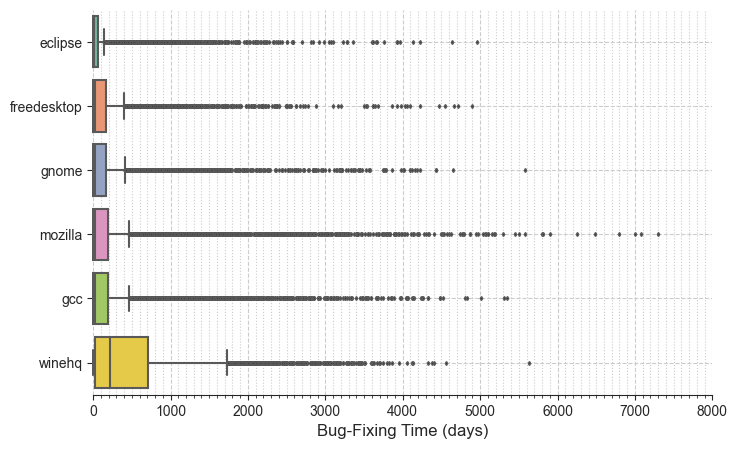

In [30]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
sns.despine(offset=10)
sns.set_style("ticks")
threshold = 8000

fig, ax = plt.subplots(figsize=(8, 5))
df = bug_reports_all_data.loc[(bug_reports_all_data["bug_fix_time"] < threshold)] 
g  = sns.boxplot(data=df, x="bug_fix_time", y="project", palette="Set2", ax=ax, showfliers = True, flierprops = dict(markerfacecolor = '.10', markersize = 2))
plt.ylabel("", fontsize= 12)
plt.xlabel("Bug-Fixing Time (days)", fontsize= 12)
plt.title("", fontsize= 15)
ax.yaxis.grid(True)
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.set(xlim=( -10, threshold))
sns.despine(trim=True, left=True)
plt.savefig(f"figures/rq2-bug-fix-time-distribution.pdf", format="pdf", dpi=600, bbox_inches='tight')

### Step 5. How frequent are long-lived bugs?

In [31]:
def plot_pyramid (data, column, filename):
  
    top_g = data.groupby(column)[column].agg(['count'])
    top_s = top_g.sort_values('count', ascending=False)
    top_n = data.loc[data[column].isin(top_s.index)].groupby(column)['long_lived?'].value_counts(normalize=True).unstack()
    top_n.fillna(0, inplace=True)
    
    top_n.reset_index(inplace=True)
    top_n = top_n.sort_values('long-lived', ascending=True)
    
    print(top_n)
    
    fig, axes = plt.subplots(figsize=(10, 10), ncols=2, sharey=False, gridspec_kw = {'wspace':0, 'hspace':0})

    plt.rcParams["axes.grid.axis"] ="x"
    plt.rcParams["axes.grid"] = True

    sns.despine(offset=0.5)
    sns.barplot(x="long-lived", y=column, color="tab:red", ax=axes[0], data=top_n)
    sns.barplot(x="short-lived", y=column,  color="tab:blue", ax=axes[1], data=top_n)
    
    axes[0].set(xlim=(0, 1))
    axes[0].invert_xaxis()
    axes[0].spines['left'].set_visible(False)
    axes[0].tick_params(axis="x", labelsize=MEDIUM_SIZE+3)
    axes[0].tick_params(axis="y", labelsize=MEDIUM_SIZE+3)
    axes[0].set_ylabel(column.title().replace("_", " ").replace("Category", "Level"), fontsize=MEDIUM_SIZE+2)
    axes[0].set_xlabel("Long-lived", fontsize=MEDIUM_SIZE+3)    
    axes[0].set_xticklabels(['{:,.0%}'.format(x) for x in axes[0].get_xticks()])
    
    axes[1].set(xlim=(0, 1))
    axes[1].set_yticks([])
    axes[1].set(ylabel="")
    axes[1].tick_params(axis="x", labelsize=MEDIUM_SIZE+3)
    axes[1].set_xlabel("Short-lived", fontsize=MEDIUM_SIZE+3)
    axes[1].set_xticklabels(['{:,.0%}'.format(x) for x in axes[1].get_xticks()])
    
    #sns.despine(offset=0.5)
    s = axes[1].twinx()
    labels = [i.get_text() for i in axes[0].get_yticklabels()]
    labels_new = [top_s.loc[top_s.index==i, 'count'].values[0] for i in labels]
    s.set_yticks(axes[0].get_yticks())
    s.set_ylim(axes[0].get_ylim())
    s.set_yticklabels(labels_new)
    s.tick_params(axis="y", labelsize=MEDIUM_SIZE+3)
    
    s.spines['top'].set_visible(False)
    s.spines['bottom'].set_visible(False)
    s.spines['right'].set_visible(False)
    s.spines['left'].set_visible(False)
        
    #fig.suptitle(project, fontsize=BIGGER_SIZE)
    plt.savefig(f"figures/{filename}", format="pdf", dpi=600, bbox_inches='tight')

def plot_bar (data, filename):
    
    top_g = data.groupby("project")["project"].agg(['count'])
    top_s = top_g.sort_values('count', ascending=False)
    top_n = data.loc[data['project'].isin(top_s.index)].groupby('project')['long_lived?'].value_counts(normalize=True).unstack()
    
    plt.figure(figsize=(20,20))
    fig, axis = plt.subplots(figsize=(10, 10)) 
    
    sns.despine(offset=5)
    primary   = top_n.plot(kind='barh', stacked='True',  grid='True', color=["tab:red", "tab:blue"], ax=axis)
    secondary = primary.twinx()
    
    labels = [i.get_text() for i in primary.get_yticklabels()]
    labels_new = [top_s.loc[top_s.index==i, 'count'].values[0] for i in labels]
    
    primary.set(xlim=(0, 1))
    primary.set_xlabel('percentage', fontsize=MEDIUM_SIZE)
    primary.set_ylabel('FLOSS Projects', fontsize=MEDIUM_SIZE) 
    primary.set_title("project", fontsize=BIGGER_SIZE)
    primary.tick_params(axis="y", labelsize=MEDIUM_SIZE)
    primary.tick_params(axis="x", labelsize=MEDIUM_SIZE)
    
    secondary.set_yticks(primary.get_yticks())
    secondary.set_ylim(primary.get_ylim())
    secondary.set_yticklabels(labels_new)
    secondary.tick_params(axis="y", labelsize=MEDIUM_SIZE)
    
    plt.savefig(f"figures/{filename}", format="pdf", dpi=600, bbox_inches='tight')


long_lived?      project  long-lived  short-lived
0                eclipse    0.072604     0.927396
1            freedesktop    0.136970     0.863030
3                  gnome    0.145394     0.854606
2                    gcc    0.164388     0.835612
4                mozilla    0.180694     0.819306
5                 winehq    0.407156     0.592844


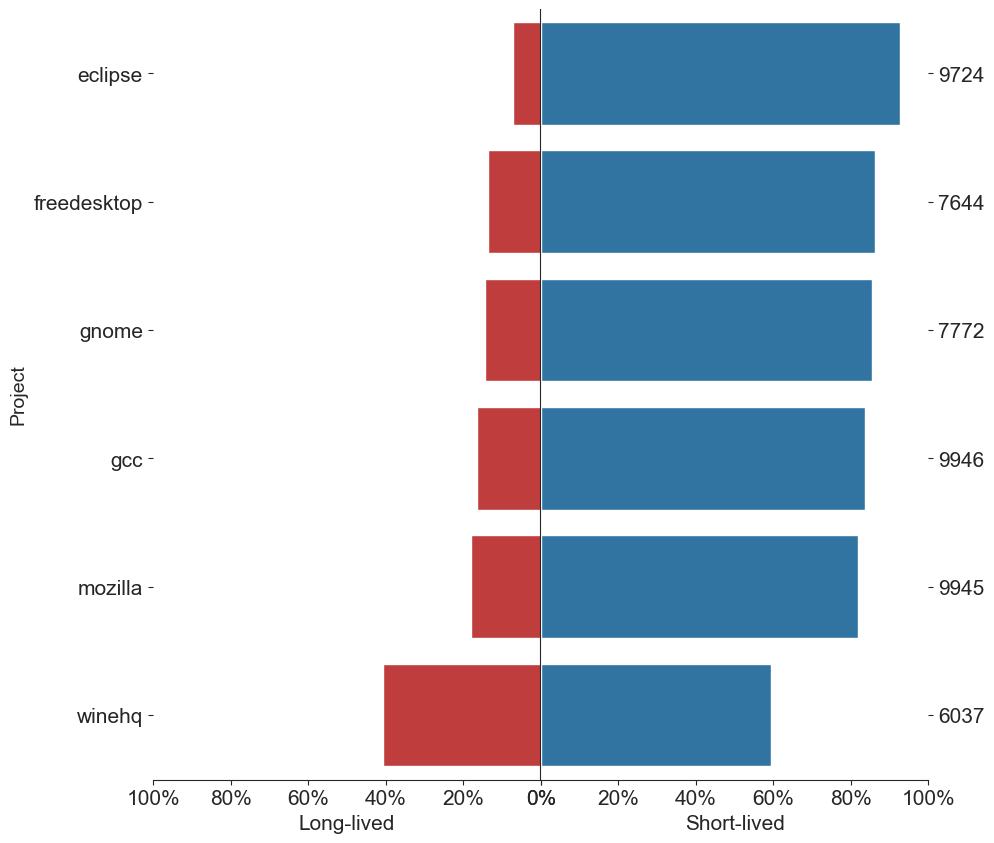

In [32]:
plot_pyramid(bug_reports_all_data, 'project', 'rq2-all-percentage-of-long-lived-bugs.pdf')